<a href="https://colab.research.google.com/github/harvey007y/CreditCardFraudLogisticRegression/blob/master/CreditCardFraudLogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation Dependencies 

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import io
import sys

# installing is needed if you are not using colab, but I am using colab
# Install a conda package in the current Jupyter kernel
#!conda install --yes --prefix {sys.prefix} altair

#!conda install --yes --prefix {sys.prefix} lightgb

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_auc_score

import altair as alt
from altair.vega import v5
# alt.renderers.enable('notebook')
# from v5 import render
from IPython.display import HTML
from sklearn import preprocessing



import gc, datetime, random

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit


In [0]:
# from google.colab import files
# uploaded = files.upload()

In [0]:
# Go to myaccount in Kaggle and generate an API key,
# then in colab execute the following command to load the dataset:-

import os
os.environ['KAGGLE_USERNAME'] = 'xxxx' # username from the json file 
os.environ['KAGGLE_KEY'] = 'xxxx' # key from the json file 

In [5]:
!kaggle competitions download -c ieee-fraud-detection

train_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_transaction.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_identity.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip test_transaction.csv.zip

Archive:  train_identity.csv.zip
replace train_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train_transaction.csv   
Archive:  test_identity.csv.zip
replace test_identity.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_identity.csv       
Archive:  test_transaction.csv.zip
replace test_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test_transaction.csv    


# Read Train Data

In [0]:
# Read the CSV file
# train_identity = pd.read_csv('kaggle/input/ieee-fraud-detection/train_identity.csv')
# train_identity = pd.read_csv(io.BytesIO(uploaded['train_identity.csv']))
train_identity = pd.read_csv('./train_identity.csv')
# train_transaction = pd.read_csv('kaggle/input/ieee-fraud-detection/train_transaction.csv')
# train_transaction =  pd.read_csv(io.BytesIO(uploaded['train_transaction.csv']))
train_transaction = pd.read_csv('./train_transaction.csv')

In [10]:
train_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


This data seems quite huge and hard to understand. TransactionID is the common column in both transaction data and identity data and the two tables can be joined using this common column.

In [0]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [12]:
print(f'Train dataset: {train.shape[0]} rows & {train.shape[1]} columns')

Train dataset: 590540 rows & 434 columns


# Reduce Memory

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
# train = reduce_mem_usage(train) # not needed in colab

We have merged the train_transaction and train_identity into a single table called train . So we can delete the extra info.

In [0]:
del train_identity, train_transaction

# Read Test Data

In [0]:
# Read the CSV file
# test_identity = pd.read_csv('kaggle/input/ieee-fraud-detection/test_identity.csv')
# test_identity = pd.read_csv(io.BytesIO(uploaded['test_identity.csv']))
test_identity = pd.read_csv('./test_identity.csv')
# test_transaction = pd.read_csv('kaggle/input/ieee-fraud-detection/test_transaction.csv')
# test_transaction =  pd.read_csv(io.BytesIO(uploaded['test_transaction.csv']))
test_transaction = pd.read_csv('./test_transaction.csv')

In [0]:
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [18]:
print(f'Test dataset: {test.shape[0]} rows & {test.shape[1]} columns')

Test dataset: 506691 rows & 433 columns


In [19]:
list(test.columns)

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',

In [0]:
# test = reduce_mem_usage(test)

We have merged the test_transaction and ttest_identity into a single table called test. So we can delete the extra info.

In [0]:
del  test_identity, test_transaction

## Recognize categorical and numerical attributes

Now let's recognize the categorical data and numerical data.

In [22]:
cat_cols = list(train.select_dtypes(include=['object']).columns)
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

# Recognize missing data

In a real dataset, it is common to have many null attributes.

In [23]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.head()

,Missing Ratio
id_24,99.196159
id_25,99.130965
id_07,99.127070
id_08,99.127070
id_21,99.126393


In [24]:
missing_data.shape

(414, 1)

There are 414 attributes containing null values.

Now we will delete attributes with more than 90 percent missing value.

In [0]:
def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols

In [0]:
def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if train[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols

In [0]:
def get_useless_columns(data):
    too_many_null = get_too_many_null_attr(data)
    print("More than 90% null: " + str(len(too_many_null)))
    too_many_repeated = get_too_many_repeated_val(data)
    print("More than 90% repeated value: " + str(len(too_many_repeated)))
    cols_to_drop = list(set(too_many_null + too_many_repeated))
    cols_to_drop.remove('isFraud')
    return cols_to_drop

In [28]:
cols_to_drop = get_useless_columns(train)

More than 90% null: 12
More than 90% repeated value: 67


Text(0, 0.5, 'Missing rate')

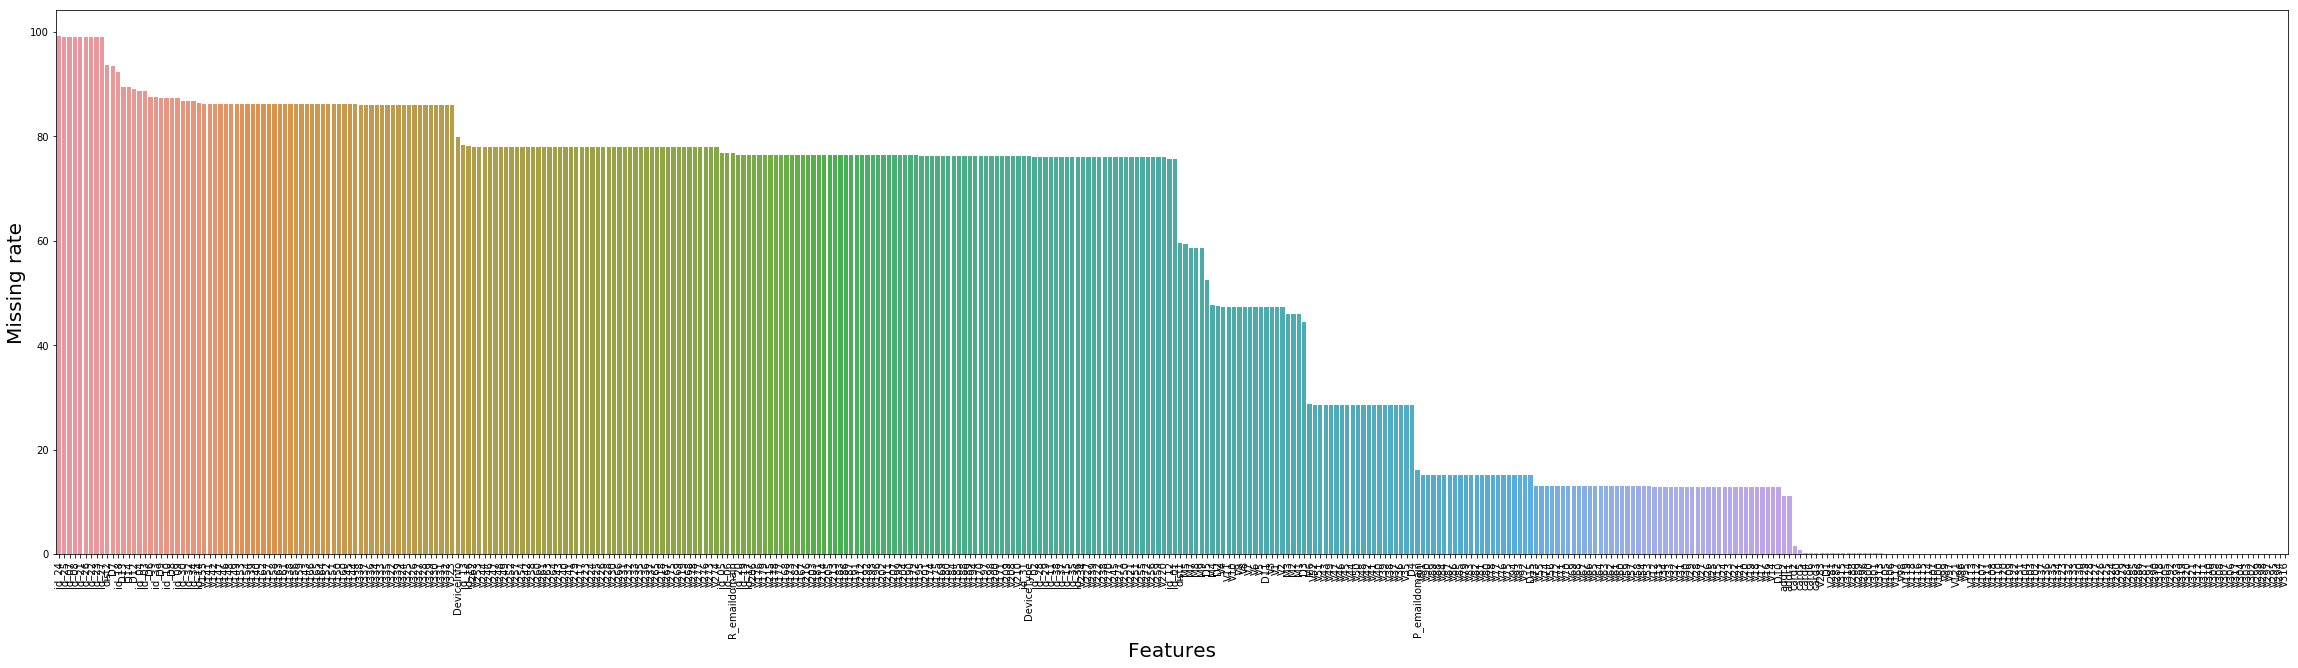

In [29]:
plt.subplots(figsize=(40,10))
plt.xticks(rotation='90')
sns.barplot(data_null.index, data_null)
plt.xlabel('Features', fontsize=20)
plt.ylabel('Missing rate', fontsize=20)

# Knowing the Data

In [30]:
train['id_03'].value_counts(dropna=False, normalize=True).head()

NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64

As you can see, 88% of values are missing and 10% of them are equal to 0. So, 98% of data is either missing or 0. This attribute does not seem to be helpful.

In [31]:
train['id_11'].value_counts(dropna=False, normalize=True).head()

NaN           0.761273
100.000000    0.225492
95.080002     0.002085
95.160004     0.001277
97.120003     0.000745
Name: id_11, dtype: float64

Here we see that 76% of data is missing and more that 22% is equal to 100. This does not seem useful either.

In [32]:
list(train.columns)

['TransactionID',
 'isFraud',
 'TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V

In [33]:
for i in range(1, 10):
    print(train['id_0' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')
    
for i in range(10, 39):
    print(train['id_' + str(i)].value_counts(dropna=False, normalize=True).head())
    print('\n')

 NaN     0.755761
-5.0     0.139144
 0.0     0.033114
-10.0    0.019062
-20.0    0.018984
Name: id_01, dtype: float64


NaN       0.761452
1102.0    0.000019
696.0     0.000017
1116.0    0.000015
1120.0    0.000015
Name: id_02, dtype: float64


NaN    0.887689
0.0    0.108211
1.0    0.001461
3.0    0.001131
2.0    0.000713
Name: id_03, dtype: float64


 NaN    0.887689
 0.0    0.111320
-5.0    0.000224
-6.0    0.000166
-8.0    0.000108
Name: id_04, dtype: float64


NaN    0.768238
0.0    0.157048
1.0    0.014043
2.0    0.008360
3.0    0.006526
Name: id_05, dtype: float64


 NaN    0.768238
 0.0    0.154647
-1.0    0.007937
-5.0    0.006518
-6.0    0.005515
Name: id_06, dtype: float64


NaN     0.991271
0.0     0.000693
16.0    0.000415
14.0    0.000386
12.0    0.000352
Name: id_07, dtype: float64


 NaN      0.991271
-100.0    0.000847
 0.0      0.000442
-34.0     0.000435
-33.0     0.000354
Name: id_08, dtype: float64


NaN    0.873123
0.0    0.119176
1.0    0.002736
3.0    0.001636
2

Let's visualize the categorical ones which are:

['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

In [0]:
charts = {}
info = []
for i in range(12, 39):
    info.append('id_' + str(i))
for i in info:
    width_len = 400
    if i in ['id_30', 'id_31', 'id_33']:
        width_len = 600
    feature_count = train[i].value_counts(dropna=False).reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                y=alt.Y(f"{i}:N", axis=alt.Axis(title=i)),
                x=alt.X('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=width_len)
    charts[i] = chart                         


for i in ['id_30', 'id_31', 'id_33']:
    feature_count = train[i].value_counts(dropna=False)[:40].reset_index().rename(columns={i: 'count', 'index': i})
    chart = alt.Chart(feature_count).mark_bar().encode(
                x=alt.X(f"{i}:N", axis=alt.Axis(title=i)),
                y=alt.Y('count:Q', axis=alt.Axis(title='Count')),
                tooltip=[i, 'count']
            ).properties(title=f"Counts of {i}", width=800)
    charts[i] = chart
    
# render((charts['id_12'] | charts['id_15']) & 
#       (charts['id_16'] | charts['id_23']) & 
#       (charts['id_27'] | charts['id_28']) & 
#       (charts['id_29'] | charts['id_34']) & 
#       (charts['id_35'] | charts['id_36']) &
#       (charts['id_37'] | charts['id_38']))

# Feature Engineering

In [0]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

## Add New Features

In [0]:
SEED = 42
seed_everything(SEED)
TARGET = 'isFraud'
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [0]:
def addNewFeatures(data): 
    data['uid'] = data['card1'].astype(str)+'_'+data['card2'].astype(str)

    data['uid2'] = data['uid'].astype(str)+'_'+data['card3'].astype(str)+'_'+data['card5'].astype(str)

    data['uid3'] = data['uid2'].astype(str)+'_'+data['addr1'].astype(str)+'_'+data['addr2'].astype(str)
    
    return data

In [0]:
train = addNewFeatures(train)
test = addNewFeatures(test)

In [0]:
i_cols = ['card1','card2','card3','card5','uid','uid2','uid3']

for col in i_cols:
    for agg_type in ['mean','std']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp_df = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])
        #temp_df['TransactionAmt'] = temp_df['TransactionAmt'].astype(int)
        temp_df = temp_df.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp_df.index = list(temp_df[col])
        temp_df = temp_df[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp_df)
        test[new_col_name]  = test[col].map(temp_df)

In [0]:
train = train.replace(np.inf,999)
test = test.replace(np.inf,999)

In [0]:
train['TransactionAmt'] = np.log1p(train['TransactionAmt'])
test['TransactionAmt'] = np.log1p(test['TransactionAmt'])

## Handle Email Domains
As you may have noticed, for some companies there are several email addresses. For a better analysis we will consider them same as each other.

In [0]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

Handle P Email Domain and R Email Domain

In [0]:
p = 'P_emaildomain'
r = 'R_emaildomain'
uknown = 'email_not_provided'

def setDomain(df):
    df[p] = df[p].fillna(uknown)
    df[r] = df[r].fillna(uknown)
    
    # Check if P_emaildomain matches R_emaildomain
    df['email_check'] = np.where((df[p]==df[r])&(df[p]!=uknown),1,0)

    df[p+'_prefix'] = df[p].apply(lambda x: x.split('.')[0])
    df[r+'_prefix'] = df[r].apply(lambda x: x.split('.')[0])
    
    return df
    
train=setDomain(train)
test=setDomain(test)

Set Time

In [0]:
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df
    
train=setTime(train)
test=setTime(test)

Handle Browser version

In [0]:
train["lastest_browser"] = np.zeros(train.shape[0])
test["lastest_browser"] = np.zeros(test.shape[0])

def setBrowser(df):
    df.loc[df["id_31"]=="samsung browser 7.0",'lastest_browser']=1
    df.loc[df["id_31"]=="opera 53.0",'lastest_browser']=1
    df.loc[df["id_31"]=="mobile safari 10.0",'lastest_browser']=1
    df.loc[df["id_31"]=="google search application 49.0",'lastest_browser']=1
    df.loc[df["id_31"]=="firefox 60.0",'lastest_browser']=1
    df.loc[df["id_31"]=="edge 17.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 69.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 67.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 63.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 64.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 65.0 for ios",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for android",'lastest_browser']=1
    df.loc[df["id_31"]=="chrome 66.0 for ios",'lastest_browser']=1
    return df

train=setBrowser(train)
test=setBrowser(test)

Handle Device Type

In [0]:
def setDevice(df):
    df['DeviceInfo'] = df['DeviceInfo'].fillna('unknown_device').str.lower()
    
    df['device_name'] = df['DeviceInfo'].str.split('/', expand=True)[0]

    df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    df['had_id'] = 1
    gc.collect()
    
    return df

train=setDevice(train)
test=setDevice(test)

Set Frequency

In [0]:
i_cols = ['card1','card2','card3','card5',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'D1','D2','D3','D4','D5','D6','D7','D8',
          'addr1','addr2',
          'dist1','dist2',
          'P_emaildomain', 'R_emaildomain',
          'DeviceInfo','device_name',
          'id_30','id_33',
          'uid','uid2','uid3',
         ]

for col in i_cols:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts(dropna=False).to_dict()   
    train[col+'_fq_enc'] = train[col].map(fq_encode)
    test[col+'_fq_enc']  = test[col].map(fq_encode)


for col in ['DT_M','DT_W','DT_D']:
    temp_df = pd.concat([train[[col]], test[[col]]])
    fq_encode = temp_df[col].value_counts().to_dict()
            
    train[col+'_total'] = train[col].map(fq_encode)
    test[col+'_total']  = test[col].map(fq_encode)

periods = ['DT_M','DT_W','DT_D']
i_cols = ['uid']
for period in periods:
    for col in i_cols:
        new_column = col + '_' + period
            
        temp_df = pd.concat([train[[col,period]], test[[col,period]]])
        temp_df[new_column] = temp_df[col].astype(str) + '_' + (temp_df[period]).astype(str)
        fq_encode = temp_df[new_column].value_counts().to_dict()
            
        train[new_column] = (train[col].astype(str) + '_' + train[period].astype(str)).map(fq_encode)
        test[new_column]  = (test[col].astype(str) + '_' + test[period].astype(str)).map(fq_encode)
        
        train[new_column] /= train[period+'_total']
        test[new_column]  /= test[period+'_total']

In [48]:
train.shape

(590540, 516)

In [49]:
test.shape

(506691, 515)

## Prepare Data for Train

In [0]:
train = train.drop(cols_to_drop, axis=1)


In [0]:
class ModifiedLabelEncoder(LabelEncoder):
    def fit_transform(self, y, *args, **kwargs):
        return super().fit_transform(y).reshape(-1, 1)

    def transform(self, y, *args, **kwargs):
        return super().transform(y).reshape(-1, 1)

In [0]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attr):
        self.attributes = attr
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes].values

In [0]:
noisy_cols = [
    'TransactionID','TransactionDT',                      # Not target in features))
    'uid','uid2','uid3',                                 
    'DT','DT_M','DT_W','DT_D',       
    'DT_hour','DT_day_week','DT_day',
    'DT_D_total','DT_W_total','DT_M_total',
    'id_30','id_31','id_33',
    'D1', 'D2', 'D9',
]

noisy_cat_cols = list(train[noisy_cols].select_dtypes(include=['object']).columns) 
noisy_num_cold = list(train[noisy_cols].select_dtypes(exclude=['object']).columns)

In [54]:
cat_attr = list(train.select_dtypes(include=['object']).columns)
num_attr = list(train.select_dtypes(exclude=['object']).columns)
num_attr.remove('isFraud')

for col in noisy_cat_cols:
    if col in cat_attr:
        print("Deleting " + col)
        cat_attr.remove(col)
for col in noisy_num_cold:
    if col in num_attr:
        print("Deleting " + col)
        num_attr.remove(col)

Deleting uid
Deleting uid2
Deleting uid3
Deleting id_30
Deleting id_31
Deleting id_33
Deleting TransactionID
Deleting TransactionDT
Deleting DT
Deleting DT_M
Deleting DT_W
Deleting DT_D
Deleting DT_hour
Deleting DT_day_week
Deleting DT_day
Deleting DT_D_total
Deleting DT_W_total
Deleting DT_M_total
Deleting D1
Deleting D2
Deleting D9


In [0]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attr)),
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', StandardScaler()),
    ]) 

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attr)),
        ('imputer', SimpleImputer(strategy="most_frequent")),
    ])


full_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
])

Now we need to deal with categorical data

In [0]:
def encodeCategorical(df_train, df_test):
    for f in df_train.drop('isFraud', axis=1).columns:
        if df_train[f].dtype=='object' or df_test[f].dtype=='object': 
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df_train[f].values) + list(df_test[f].values))
            df_train[f] = lbl.transform(list(df_train[f].values))
            df_test[f] = lbl.transform(list(df_test[f].values))
    return df_train, df_test

In [0]:
y_train = train['isFraud']
train, test = encodeCategorical(train, test)

In [58]:
train.shape


(590540, 450)

In [59]:
test.shape

(506691, 515)

In [62]:
X_train = pd.DataFrame(full_pipeline.fit_transform(train))
gc.collect()

328

In [0]:
del train

In [0]:
# X_test = pd.DataFrame(full_pipeline.fit_transform(test))
# gc.collect()

# Logistic Regression Model

We prepare the test data with the pipeline we had so it will be ready to be used for prediction.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)


In [0]:

from sklearn.linear_model import LogisticRegression  
from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

In [67]:
lr = LogisticRegression(solver='lbfgs')  
lr.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [68]:
lr.score(X_test, y_test)

0.9702645036746029

In [0]:
y_pred=lr.predict(X_test)

In [70]:

pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,113668,198,113866
1,3314,928,4242
All,116982,1126,118108


In [71]:
recall_score(y_test, y_pred)

0.21876473361621876

In [72]:
accuracy_score(y_test, y_pred)

0.9702645036746029

# Prepare Kaggle Test Data for Submission

In [0]:
X_test_submission = test.drop(cols_to_drop, axis=1)
X_test_submission = pd.DataFrame(full_pipeline.transform(X_test_submission))

In [74]:
import csv

y_sub_predict = lr.predict_proba(X_test_submission)

csv_data = [['TransactionID', 'isFraud']]

fraud_dict = { 'fraud': 0, 'not_fraud': 0 }
for i in range(0, len(y_sub_predict)):
  csv_data.append([test['TransactionID'][i], y_sub_predict[i][0]])
  if y_sub_predict[i][0] >= 0.5:
    fraud_dict['fraud'] += 1
  else:
    fraud_dict['not_fraud'] += 1
print(fraud_dict)

{'fraud': 500948, 'not_fraud': 5743}


In [0]:
with open('submission.csv', 'w') as csv_file:
  writer = csv.writer(csv_file)
  writer.writerows(csv_data)

csv_file.close()

In [78]:
submission = pd.read_csv('./submission.csv')
submission.head()

,TransactionID,isFraud
0,3663549,0.992966
1,3663550,0.987027
2,3663551,0.953843
3,3663552,0.991087
4,3663553,0.986179


In [0]:
from google.colab import files
files.download('./submission.csv')